In [9]:
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import torch
from policy import DPAgent
from datetime import datetime
from pytz import timezone

from simulation import Simulator, CustomerGenerator
from hazard_models import ExponentialHazard
from utility_learner import ProjectedVolumeLearner, diam
from degradation_learner import DegradationLearner

from utils import unit_ball_rejection_sample, correct_signs
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import logging
logging.basicConfig(level=logging.INFO)

np.set_printoptions(suppress=True)

In [10]:
# --- 2. Define Sampling Functions ---
# def context_sampler() -> np.ndarray:
#     """Samples a customer's context vector from a uniform distribution."""
#     return np.random.uniform(low=0.0, high=1.0, size=D)

def context_sampler() -> np.ndarray:
    """Samples a customer's context vector uniformly from the unit ball."""
    return np.abs(unit_ball_rejection_sample(D))

def rental_sampler() -> float:
    """Samples a customer's desired rental duration from an exponential distribution."""
    return np.random.exponential(scale=10.0)

def interarrival_sampler() -> float:
    """Samples the time until the next customer arrives."""
    return np.random.exponential(scale=5.0)

In [19]:
# --- 1. Simulation Configuration ---
D = 4                                  # Dimension of context vectors
LAMBDA_VAL = 0.001                     # Baseline hazard constant
NUM_CUSTOMERS = 20000                   # Total number of customers to simulate, i.e. T

# Set a random seed for reproducibility
np.random.seed(41)

# Ground truth vectors
THETA_TRUE = np.array([0.5, 0.2, 0.4, 0.3])#$, 0.4])    # For degradation
UTILITY_TRUE = np.array([0.12450167, 0.10850869, 0.43930126, 0.71356037]) # context_sampler()  # For customer's willingness to pay

# --- Machine's Pricing Vector 'r' ---
# This is a fallback pricing vector, when we don't feed u_hat to calculate_price
PRICING_R = np.zeros(D)

In [12]:
usage_exp_hazard_model = ExponentialHazard(lambda_val=LAMBDA_VAL)
# spontaneous_exp_hazard_model = None # ExponentialHazard(lambda_val=0.01)

customer_gen = CustomerGenerator(
    d=D,
    context_sampler=context_sampler,
    rental_sampler=rental_sampler,
    interarrival_sampler=interarrival_sampler
)

centroid_params = {
    # 'num_samples': 2000,
    # 'thin': None,
    # 'burn_in': 500 * D ** 2,
    # 'tol': 1e-4,
    # 'rho_target': 0.01
}

termination_rule = lambda diameter: diameter < 0.0005  # Example custom termination rule

projected_volume_learner = ProjectedVolumeLearner(
    T=NUM_CUSTOMERS, 
    d=D, 
    centroid_params=centroid_params,
    incentive_constant=1.1,
    termination_rule=termination_rule,
)

mdp_params = {
    'replacement_cost': 1.5,   # Cost to replace the machine
    'failure_cost': 0.75,      # Additional penalty for in-service failure
    'holding_cost_rate': 0.02,   # Cost per unit of idle time
    'gamma': 0.99,             # Discount factor
    'learning_rate': 1e-3,      # Learning rate for the Adam optimizer
    'target_update_freq': 10    # How often to update the target network (in iterations)
}

training_hyperparams = {
    'num_iterations': 50, # Number of training iterations per policy update
    'dataset_size': 200000,      # Number of transitions to generate for the offline dataset
    'batch_size': 256           # Batch size for training
}

policy_params = {
    'type': 'softmax',
    'tau': 1.0,
    'epsilon': 0.1,
}

# Instantiate the Simulator with the new parameters
simulator = Simulator(
    d=D,
    T=NUM_CUSTOMERS,
    
    theta_true=THETA_TRUE,
    utility_true=UTILITY_TRUE,
    pricing_r=PRICING_R,
    
    usage_hazard_model=usage_exp_hazard_model,
    customer_generator=customer_gen,
    projected_volume_learner=projected_volume_learner,  # Use default ProjectedVolumeLearner
    
    mdp_params=mdp_params,
    training_hyperparams=training_hyperparams,
    policy_params=policy_params,
    policy_update_threshold=20,
    time_normalize=True,
)

In [ ]:
# get current time in "YYYYMMDD_HHMMSS" in pacific time
pacific_tz = timezone('America/Los_Angeles')
current_time = datetime.now(pacific_tz).strftime("%Y%m%d_%H%M%S")

# simulator.projected_volume_learner.is_terminated = True
simulation_data = simulator.run(num_customers=NUM_CUSTOMERS)
degradation_df = pd.DataFrame(simulator.degradation_history)
simulation_df = pd.DataFrame(simulator.history)

simulation_df['net_profit'] = simulation_df['profit'] + simulation_df['loss']
simulation_df['cumulative_net_profit'] = simulation_df['net_profit'].cumsum()

degradation_df.to_csv(f'data/degradation_data_{current_time}.csv', index=False)
simulation_df.to_csv(f'data/simulation_data_{current_time}.csv', index=False)
simulator.save(f'models/simulator_{current_time}')

### Convergence of $\hat\theta$

In [ ]:
degradation_history

In [ ]:
degradation_history.event.sum() / len(degradation_history)

In [ ]:
# simulator = Simulator.load('models/simulator_0914')

history = pd.DataFrame(simulator.history)
degradation_history = pd.DataFrame(simulator.degradation_history)

times = []

for d in simulator.theta_updates:
    idx, theta_hat = d['customer_idx'], d['theta_hat']
    time = history[history.customer_id == idx]['calendar_time'].max()
    times.append(time)
    
# plot L2, and L-inf norms of utility updates
L2_errors = [np.linalg.norm(update['theta_hat'] - THETA_TRUE) for update in simulator.theta_updates]
Linf_errors = [np.linalg.norm(update['theta_hat'] - THETA_TRUE, ord=np.inf) for update in simulator.theta_updates]

plt.figure(figsize=(12, 6))
plt.plot(times, L2_errors, label='$L_2$ Norm Error', marker='o')
plt.plot(times, Linf_errors, label='$L_\infty$ Norm Error', marker='x')
# plt.yscale('log')
plt.xlabel('Number of Customers Processed', fontsize=14)
plt.ylabel('Error Norm', fontsize=14)

plt.title('Convergence of $\|\hat{\\theta} - \\theta\|$', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('figures/utility_convergence.pdf')
plt.show()

### Convergence of $\hat u$

In [ ]:
simulator.utility_updates

# plot L2, and L-inf norms of utility updates
L2_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE) for update in simulator.utility_updates]
Linf_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE, ord=np.inf) for update in simulator.utility_updates]

plt.figure(figsize=(12, 6))
plt.plot(L2_errors, label='$L_2$ Norm Error', marker='o')
plt.plot(Linf_errors, label='$L_\infty$ Norm Error', marker='x')
# plt.yscale('log')
plt.xlabel('Number of Customers Processed', fontsize=14)
plt.ylabel('Error Norm', fontsize=14)

plt.title('Convergence of $\|\hat u - u\|$', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('figures/utility_convergence.pdf')
plt.show()

### Revenue of Online Learner

In [ ]:
degradation_df = pd.DataFrame(simulator.degradation_history)
simulation_df = pd.DataFrame(simulator.history)

simulation_df['net_profit'] = simulation_df['profit'] + simulation_df['loss']
simulation_df['cumulative_net_profit'] = simulation_df['net_profit'].cumsum()

ax = plt.figure(figsize=(10,6))

# plot cumulative profit and loss over time
plt.plot(simulation_df['calendar_time'], simulation_df['cumulative_net_profit'], label='Cumulative Net Profit')
plt.xlabel('Calendar Time')
plt.ylabel('Cumulative Net Profit')
plt.title('Cumulative Net Profit Over Time')
plt.legend()
plt.grid()
plt.show()

## Training policy under perfect information

### Revenue of Optimal Policy

Think about how mnay failures are met at ~200 breakdowns
-> how accurate that theta hat would be
-> how much we should be steering policy to pick argmax Q
-> use that decay rate to test optimal policy and see if it is still positive

In [ ]:
class PerfectDegradationLearner:
    def __init__(self, d, theta_true, hazard_model):
        self.d = d
        self.theta_true = theta_true
        self.hazard_model = hazard_model  # Placeholder, not used
        
    def get_theta(self):
        return self.theta_true
    
    def cum_baseline(self, t):
        return self.hazard_model.Lambda_0(t)
    
    def inverse_cum_baseline(self, u):
        return self.hazard_model.Lambda_0_inverse(u)
    
perfect_degradation_learner = PerfectDegradationLearner(
    d=D, 
    theta_true=THETA_TRUE,
    hazard_model=usage_exp_hazard_model,
)

perfect_dpagent = DPAgent(
    d=D,
    u_hat=UTILITY_TRUE,
    time_normalize=True,
    degradation_learner=perfect_degradation_learner,
    customer_generator=customer_gen,
    params=mdp_params,
)

# weight = torch.load('weights/perfect_dpagent_q_network.pth', map_location=torch.device('cuda'))
# perfect_dpagent.q_network.load_state_dict(weight)
# perfect_dpagent.q_network.to(perfect_dpagent.device)
# perfect_dpagent.q_network.eval()

perfect_dpagent.train(
    num_iterations=50,
    dataset_size=200000,
    batch_size=256
)

perfect_policy = perfect_dpagent.get_policy(
    {'type': 'greedy', 'epsilon': 0.1, 'tau': 1.0}
)

Using device: cuda
Generating 200000 experience samples...


100%|██████████| 200000/200000 [00:02<00:00, 72080.76it/s]



Starting FQI training loop...


 40%|████      | 20/50 [06:49<10:37, 21.25s/it]

In [14]:
perfect_policy = perfect_dpagent.get_policy(
    {'type': 'greedy', 'epsilon': 0.1, 'tau': 1.0}
)

In [15]:
samples = simulator.run_full_exploit(20000, perfect_policy)
samples = pd.DataFrame(samples)

INFO:root:Starting simulation for 20000 customers...
100%|██████████| 20000/20000 [00:14<00:00, 1423.22it/s]
INFO:root:Simulation finished.


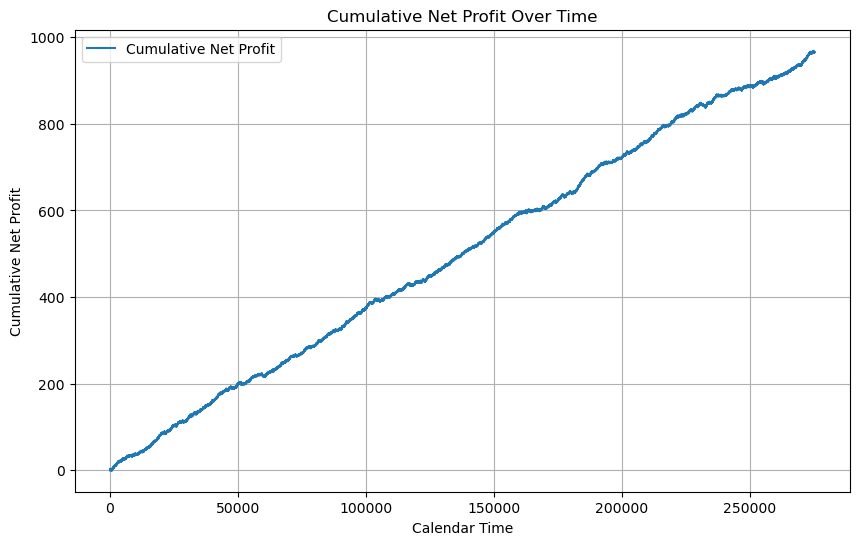

In [16]:
samples['net_profit'] = samples['profit'] + samples['loss']
samples['cumulative_net_profit'] = samples['net_profit'].cumsum()

ax = plt.figure(figsize=(10,6))

# plot cumulative profit and loss over time
plt.plot(samples['calendar_time'], samples['cumulative_net_profit'], label='Cumulative Net Profit')
plt.xlabel('Calendar Time')
plt.ylabel('Cumulative Net Profit')
plt.title('Cumulative Net Profit Over Time')
plt.legend()
plt.grid()
plt.show()